In [1]:
import pandas as pd 
import numpy as np 

from tools_tolgay import functions_readfiles as readfiles
from tools_tolgay.functions_cloudy import get_fname, read_emissivity_file, read_ovr_file
from tools_tolgay import constants

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['mathtext.fontset'] = 'cm'
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16
rcParams['figure.figsize'] = (12, 6)
rcParams['figure.dpi'] = 100


from scipy import integrate # flux calculation


In [2]:
# Read all data from Deschenes+2017

base_fdir = "/scratch/dtolgay/cloudy_runs/z_0/miville_deschenes_2017"
all_data = pd.read_csv(f"{base_fdir}/all_data.txt", sep=',')

condition = all_data['Rgal'] < 10
all_data = all_data[condition]


In [3]:
cloud_ids_selected = [36]
mask = all_data['Cloud'].isin(cloud_ids_selected)

single_run = all_data.loc[mask].copy().iloc[0] 

# find centers from the single run 
file_props = {
    'log_hden': np.log10(single_run['hden']),
    'log_metallicity': np.log10(single_run['metallicity']),
    'log_turbulence': np.log10(single_run['turbulence']),
    'log_isrf': np.log10(single_run['isrf']),
    'log_radius': np.log10(single_run['radius']),
}

fname = get_fname(file_props)

# Read the cloudy files 
emissivities = read_emissivity_file(base_dir = base_fdir, file_props = file_props)
abundances = read_ovr_file(base_dir = base_fdir, file_props = file_props)



Reading: /scratch/dtolgay/cloudy_runs/z_0/miville_deschenes_2017/hden1.60345_metallicity0.44367_turbulence0.89142_isrf0.00000_radius1.75643/hden1.60345_metallicity0.44367_turbulence0.89142_isrf0.00000_radius1.75643_em.str
Reading: /scratch/dtolgay/cloudy_runs/z_0/miville_deschenes_2017/hden1.60345_metallicity0.44367_turbulence0.89142_isrf0.00000_radius1.75643/hden1.60345_metallicity0.44367_turbulence0.89142_isrf0.00000_radius1.75643.ovr


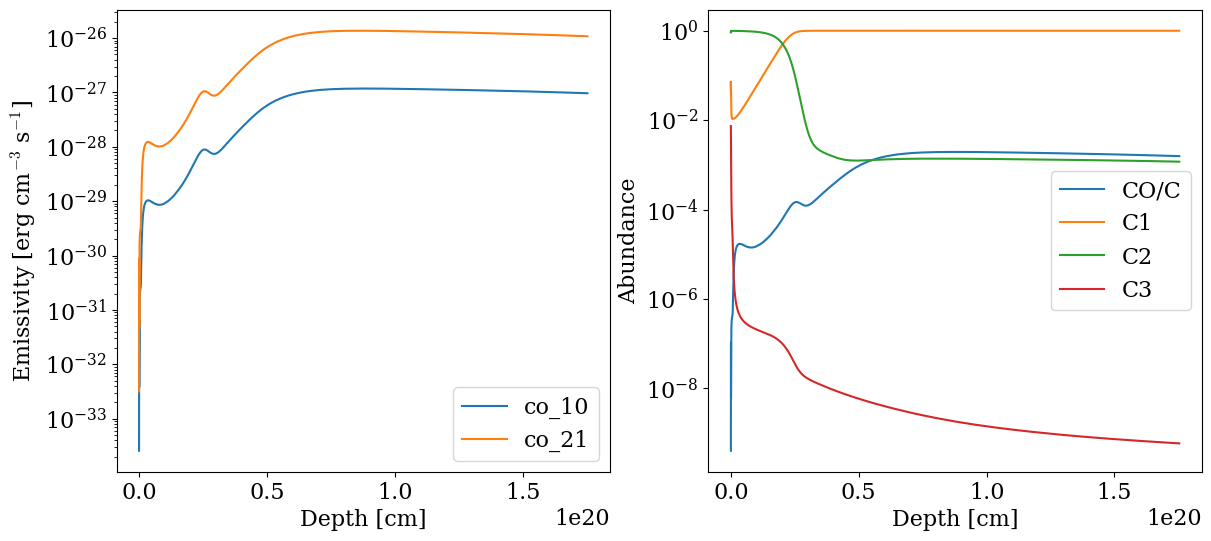

In [4]:
# columns = ['lya', 'ha', 'hb', 'co_10', 'co_21', 'co_32', 'co_43', 'co_54', 'co_65', 'co_76', 'co_87', '13co', 'c2', 'o3_88', 'o3_5006', 'o3_4958',]

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

columns = ['co_10', 'co_21']
for column in columns:
    ax = axs[0]
    ax.plot(
        emissivities['depth'], 
        emissivities[column], 
        label=column
    )

ax.set_xlabel('Depth [cm]')
ax.set_ylabel('Emissivity [erg cm$^{-3}$ s$^{-1}$]')
ax.set_yscale('log')
ax.legend()



# columns = ['depth', 'Te', 'Htot', 'hden', 'eden', '2H_2/H', 'HI', 'HII', 'HeI',
#        'HeII', 'HeIII', 'CO/C', 'C1', 'C2', 'C3', 'C4', 'O1', 'O2', 'O3', 'O4',
#        'O5', 'O6', 'H2O/O']

columns = ['CO/C', 'C1', 'C2', 'C3']
for column in columns:
    ax = axs[1]
    ax.plot(
        abundances['depth'], 
        abundances[column], 
        label=column
    )
ax.set_xlabel('Depth [cm]')
ax.set_ylabel('Abundance')
ax.set_yscale('log')
ax.legend()


plt.show()




In [10]:
Dechenes_Lco = single_run['Lco'] # K km/s pc^2


def volume_integral(emissivity):

    max_depth = emissivity['depth'].max()
    radius = (max_depth - emissivity['depth']).to_numpy()[::-1] # cm


    volume_integrals = {}
    for key in emissivity.columns:
        if key != "depth":
            emissivity_line = emissivity[key].to_numpy()[::-1]

            volume_integrals[key] = (
                integrate.simpson(y=(emissivity_line * 4 * np.pi * radius**2), x=radius)
            ) # erg s^-1     

    Lco10 = volume_integrals['co_10']

    return Lco10

def path_integral(emissivity):

    path_integrals = {}
    for key in emissivity.columns:
        if key != "depth":
            emissivity_line = emissivity[key].to_numpy()

            path_integrals[key] = (
                integrate.simpson(y=emissivity_line, x=emissivity['depth'])
            ) # erg cm^-2 s^-1

    Fco10 = path_integrals['co_10']

    return Fco10


def path_integral_norm(emissivity):

    path_integrals = {}
    for key in emissivity.columns:
        if key != "depth":
            emissivity_line = emissivity[key].to_numpy()

            path_integrals[key] = (
                integrate.simpson(y=emissivity_line, x=emissivity['depth']) / (4 * np.pi)
            ) # erg cm^-2 s^-1

    Fco10 = path_integrals['co_10'] * np.pi

    return Fco10

co10_frequency_in_Ghz = 115.2712018 # GHz

Lco10_volume_integral = volume_integral(emissivity=emissivities)
Lco10_volume_integral = Lco10_volume_integral / 3.828e33 # Lsun
Lco10_volume_integral = Lco10_volume_integral / (3e-11 * co10_frequency_in_Ghz**3) # K km/s pc^2

Fco10_path_integral = path_integral(emissivity=emissivities)
area = 4 * np.pi * (single_run['radius']*constants.pc2cm)**2 # cm^2
# area = single_run['Sn'] * (constants.pc2cm)**2 # cm^2
Lco10_path_integral = Fco10_path_integral * 4 * np.pi * area # erg/s
L_co_10 = Lco10_path_integral / 3.828e33 # Lsun
Lco10_path_integral = L_co_10 / (3e-11 * co10_frequency_in_Ghz**3) # K km/s pc^2

Fco10_path_integral_norm = path_integral_norm(emissivity=emissivities)
area = 4 * np.pi * (single_run['radius']*constants.pc2cm)**2 # cm^2
# area = single_run['Sn'] * (constants.pc2cm)**2 # cm^2
Lco10_path_integral_norm = Fco10_path_integral_norm * 4 * np.pi * area # erg/s
L_co_10 = Lco10_path_integral_norm / 3.828e33 # Lsun
Lco10_path_integral_norm = L_co_10 / (3e-11 * co10_frequency_in_Ghz**3) # K km/s pc^2


print(f"From Dechenes+2017: Lco = {Dechenes_Lco:.2e}",)
print(f"From Interpolated Emissivities Volume Integral: Lco10 = {Lco10_volume_integral:.2e}")
print(f"From Interpolated Emissivities Path Integral: Lco10 = {Lco10_path_integral:.2e}", )
print(f"From Interpolated Emissivities Path Integral Norm: Lco10 = {Lco10_path_integral_norm:.2e}", )


From Dechenes+2017: Lco = 5.65e+07
From Interpolated Emissivities Volume Integral: Lco10 = 5.68e+04
From Interpolated Emissivities Path Integral: Lco10 = 3.89e+06
From Interpolated Emissivities Path Integral Norm: Lco10 = 9.73e+05


In [6]:
single_run[['isrf', 'turbulence', 'radius', 'metallicity', 'hden', 'Lco', 'Sn']]
# single_run

isrf           1.000000e+00
turbulence     7.787967e+00
radius         5.707293e+01
metallicity    2.777608e+00
hden           4.012793e+01
Lco            5.646091e+07
Sn             2.134465e+04
Name: 35, dtype: float64

In [7]:
# all_data.iloc[[0, 5, 3, 6, 11, 7721, 7867]][['isrf', 'turbulence', 'radius', 'metallicity', 'hden', 'Lco', 'Sn']]

# all_data.iloc[[0, 3, 7867]][['isrf', 'turbulence', 'radius', 'metallicity', 'hden', 'Lco', 'Sn']]
